In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
from myfunctions import *

In [3]:
import scipy.stats

In [4]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean

from adjustText import adjust_text

In [5]:
datapd = pd.read_csv('List_model.csv')

In [6]:
# new color from https://colorbrewer2.org/
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#d9d9d9','#fdb462','#fccde5','#b3de69','#80b1d3','#bc80bd','#ccebc5']
# colors = cm.get_cmap("Set3").colors
types = datapd['type'].unique()
color_dict = {}
if len(colors) >= len(types):
    print('create new color dict')
    for i in range(len(types)):
        color_dict[types[i]] = colors[i] #lighten_color(colors[i], 0.6)

marker_list = ['o','v','^','P','X','D','h','*','s','>','<']
marker_dict = {}
if len(marker_list) >= len(types):
    print('create new marker dict')
    for i in range(len(types)):
        marker_dict[types[i]] = marker_list[i] 

create new color dict
create new marker dict


In [ ]:
polynya_areas = []
c_areas = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    if ispickleexists(name, '../../SO_data/data_mlotst/'):
        datamld = openpickle(name, '../../SO_data/data_mlotst/')
        damld = datamld.mlotst
    else:
        datamld = openpickle(name, '../../SO_data/data_mld/')
        damld = datamld.mld
   
    area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    c_areas.append(area_c.where(area_c>0).mean().values.item())

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

    polynya_areas.append(area_p.where(area_p>0).mean().values.item())
    model_type.append(datapd.at[i, 'type'])
    names.append(name)

In [ ]:
polynya_areas = []
c_areas = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    if ispickleexists(name, '../../SO_data/data_mlotst/'):
        datamld = openpickle(name, '../../SO_data/data_mlotst/')
        damld = datamld.mlotst
    else:
        datamld = openpickle(name, '../../SO_data/data_mld/')
        damld = datamld.mld
   
    area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

    if len(area_c.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            area_c=area_c.sel(time = area_p.time)
        else:
            print(name)
            break
    if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
        c_areas.append(area_c.where(area_c>0).mean().values.item())
        polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': c_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]>0.1 and df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean convective area (million km$^2$)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


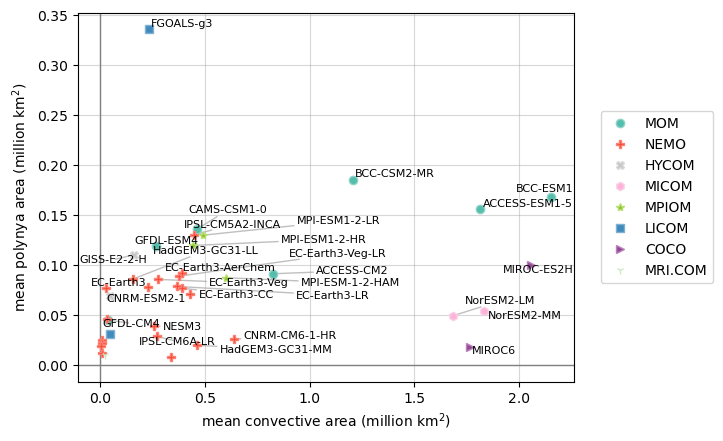

In [9]:
polynya_areas = []
c_areas = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    if ispickleexists(name, '../../SO_data/data_mlotst/'):
        datamld = openpickle(name, '../../SO_data/data_mlotst/')
        damld = datamld.mlotst
    else:
        datamld = openpickle(name, '../../SO_data/data_mld/')
        damld = datamld.mld
   
    area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

    if len(area_c.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            area_c=area_c.sel(time = area_p.time)
        else:
            print(name)
            break
    if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
        c_areas.append(area_c.where(area_c>0).mean().values.item())
        polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': c_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]>0.1 and df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean convective area (million km$^2$)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


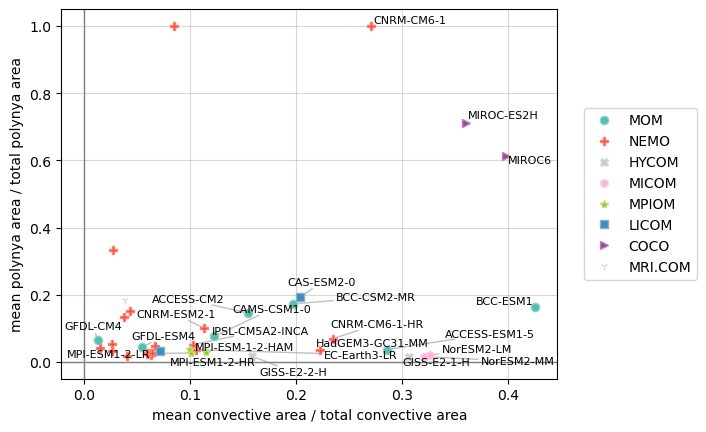

In [11]:
polynya_areas = []
c_areas = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    if ispickleexists(name, '../../SO_data/data_mlotst/'):
        datamld = openpickle(name, '../../SO_data/data_mlotst/')
        damld = datamld.mlotst
    else:
        datamld = openpickle(name, '../../SO_data/data_mld/')
        damld = datamld.mld
   
    area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    area_c_total = datamld.areacello.where(damld.where(damld>2000).mean('time')>0).sum()/1e12
    

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12
    area_p_total = dssiconc.areacello.where(dsmasked.count('time')>0).sum()/1e12

    if len(area_c.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            area_c=area_c.sel(time = area_p.time)
        else:
            print(name)
            break
    if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
        area_c_prop = area_c.where(area_c>0).mean()/area_c_total
        area_p_prop = area_p.where(area_p>0).mean()/area_p_total
        c_areas.append(area_c_prop.values.item())
        polynya_areas.append(area_p_prop.values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': c_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]>0.1 and df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean convective area / total convective area")
ax.set_ylabel("mean polynya area / total polynya area")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


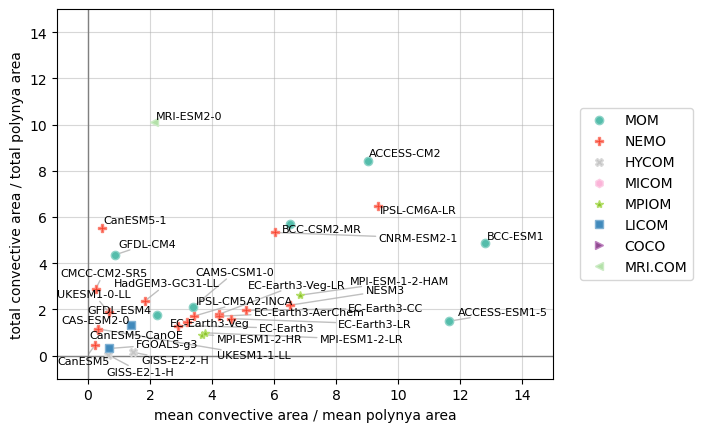

In [22]:
# polynya_areas = []
# c_areas = []
# model_type = []
# names = []
# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    
#     if ispickleexists(name, '../../SO_data/data_mlotst/'):
#         datamld = openpickle(name, '../../SO_data/data_mlotst/')
#         damld = datamld.mlotst
#     else:
#         datamld = openpickle(name, '../../SO_data/data_mld/')
#         damld = datamld.mld
   
#     area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
#     area_c_total = datamld.areacello.where(damld.where(damld>2000).mean('time')>0).sum()/1e12
    

#     path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
#     newpath = glob.glob(path_polynya)[0]
#     dsmasked = pd.read_pickle(newpath)
#     dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
#     area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12
#     area_p_total = dssiconc.areacello.where(dsmasked.count('time')>0).sum()/1e12

#     if len(area_c.time) != len(area_p.time):
#         if name in ['KIOST-ESM', 'TaiESM1']:
#             area_c=area_c.sel(time = area_p.time)
#         else:
#             print(name)
#             break
#     if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
#         area_c_prop = area_c.where(area_c>0).mean()/area_p.where(area_p>0).mean()
#         area_p_prop = area_c_total/area_p_total
#         c_areas.append(area_c_prop.values.item())
#         polynya_areas.append(area_p_prop.values.item())    
#         model_type.append(datapd.at[i, 'type'])
#         names.append(name)

# df_plot = pd.DataFrame({
#     'y': polynya_areas,
#     'x': c_areas,
#     'name': names,
#     'type': model_type
# })


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

ax.set_xlim([-1, 15])
ax.set_ylim([-1, 15])

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'abc':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]<=19:# and df_plot['y'][ind]>19:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))


# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean convective area / mean polynya area")
ax.set_ylabel("total convective area / total polynya area")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


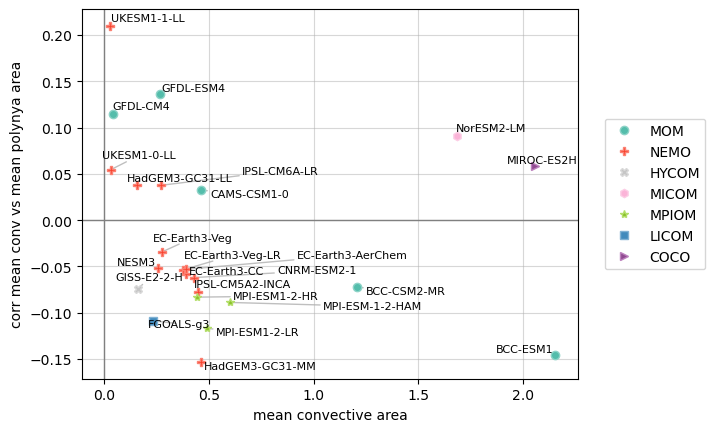

In [27]:
# polynya_areas = []
# c_areas = []
# model_type = []
# names = []
# corr_area_c_p = []
# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    
#     if ispickleexists(name, '../../SO_data/data_mlotst/'):
#         datamld = openpickle(name, '../../SO_data/data_mlotst/')
#         damld = datamld.mlotst
#     else:
#         datamld = openpickle(name, '../../SO_data/data_mld/')
#         damld = datamld.mld
   
    # area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    # area_c_total = datamld.areacello.where(damld.where(damld>2000).mean('time')>0).sum()/1e12
    

    # path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    # newpath = glob.glob(path_polynya)[0]
    # dsmasked = pd.read_pickle(newpath)
    # dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    # area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12
    # area_p_total = dssiconc.areacello.where(dsmasked.count('time')>0).sum()/1e12

    # if len(area_c.time) != len(area_p.time):
    #     if name in ['KIOST-ESM', 'TaiESM1']:
    #         area_c=area_c.sel(time = area_p.time)
    #     else:
    #         print(name)
    #         break
    # if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):

    #     corr_area = scipy.stats.pearsonr(area_c, area_p)

    #     if corr_area[1] < 0.5:
    #         corr_area_c_p.append(corr_area[0])        
    #         c_areas.append(area_c.where(area_c>0).mean().values.item())
    #         polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
    #         model_type.append(datapd.at[i, 'type'])
    #         names.append(name)

df_plot = pd.DataFrame({
    'y': corr_area_c_p,
    'x': c_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

# ax.set_xlim([-1, 15])
# ax.set_ylim([-1, 15])

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'abc':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]<=19:# and df_plot['y'][ind]>19:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))


# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean convective area")
ax.set_ylabel("corr mean conv vs mean polynya area")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


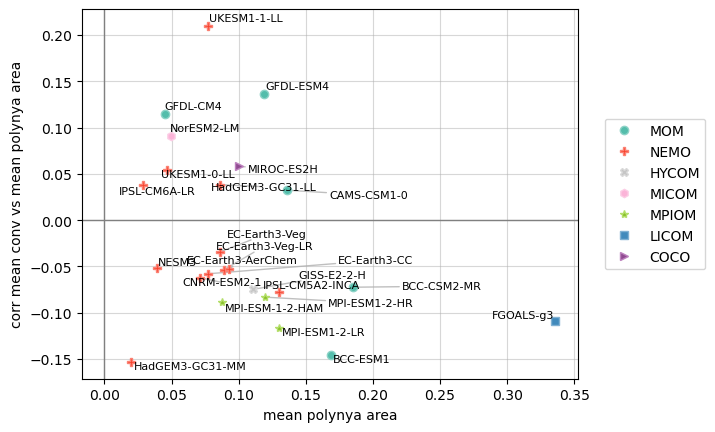

In [28]:
# polynya_areas = []
# c_areas = []
# model_type = []
# names = []
# corr_area_c_p = []
# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    
#     if ispickleexists(name, '../../SO_data/data_mlotst/'):
#         datamld = openpickle(name, '../../SO_data/data_mlotst/')
#         damld = datamld.mlotst
#     else:
#         datamld = openpickle(name, '../../SO_data/data_mld/')
#         damld = datamld.mld
   
    # area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    # area_c_total = datamld.areacello.where(damld.where(damld>2000).mean('time')>0).sum()/1e12
    

    # path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    # newpath = glob.glob(path_polynya)[0]
    # dsmasked = pd.read_pickle(newpath)
    # dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    # area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12
    # area_p_total = dssiconc.areacello.where(dsmasked.count('time')>0).sum()/1e12

    # if len(area_c.time) != len(area_p.time):
    #     if name in ['KIOST-ESM', 'TaiESM1']:
    #         area_c=area_c.sel(time = area_p.time)
    #     else:
    #         print(name)
    #         break
    # if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):

    #     corr_area = scipy.stats.pearsonr(area_c, area_p)

    #     if corr_area[1] < 0.5:
    #         corr_area_c_p.append(corr_area[0])        
    #         c_areas.append(area_c.where(area_c>0).mean().values.item())
    #         polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
    #         model_type.append(datapd.at[i, 'type'])
    #         names.append(name)

df_plot = pd.DataFrame({
    'y': corr_area_c_p,
    'x': polynya_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

# ax.set_xlim([-1, 15])
# ax.set_ylim([-1, 15])

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'abc':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]<=19:# and df_plot['y'][ind]>19:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))


# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean polynya area")
ax.set_ylabel("corr mean conv vs mean polynya area")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


Unable to allocate 562. GiB for an array with shape (200, 88, 362, 74, 320) and data type float32


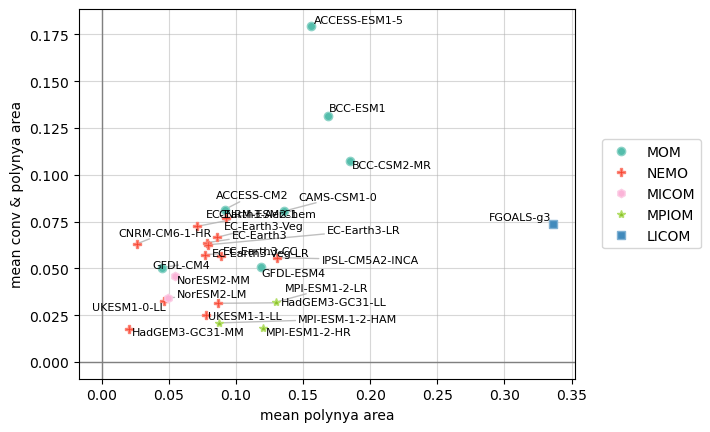

In [29]:
polynya_areas = []
c_areas = []
model_type = []
names = []
cp_areas = []

for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    if ispickleexists(name, '../../SO_data/data_mlotst/'):
        datamld = openpickle(name, '../../SO_data/data_mlotst/')
        damld = datamld.mlotst
    else:
        datamld = openpickle(name, '../../SO_data/data_mld/')
        damld = datamld.mld
   
    area_c = datamld.areacello.where(damld>=2000).sum(dim = datamld.areacello.dims)/1e12
    area_c_total = datamld.areacello.where(damld.where(damld>=2000).mean('time')>0).sum()/1e12
    

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12
    area_p_total = dssiconc.areacello.where(dsmasked.count('time')>0).sum()/1e12

    if len(area_c.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            area_c=area_c.sel(time = area_p.time)
        else:
            print(name)
            break
            
    if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
        conv_mask = damld.where(damld>=2000)
        try:
            area_cp_mask = conv_mask.where(dsmasked>0)
            area_cp = datamld.areacello.where(area_cp_mask>0).sum(dim = datamld.areacello.dims)/1e12
        except Exception as E:
            print(E)
            continue

        if area_cp.where(area_cp>0).mean()>0:
            cp_areas.append(area_cp.where(area_cp>0).mean().values.item())
            c_areas.append(area_c.where(area_c>0).mean().values.item())
            polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
            model_type.append(datapd.at[i, 'type'])
            names.append(name)

df_plot = pd.DataFrame({
    'y': cp_areas,
    'x': polynya_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

# ax.set_xlim([-1, 15])
# ax.set_ylim([-1, 15])

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'abc':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]<=19:# and df_plot['y'][ind]>19:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))


# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean polynya area")
ax.set_ylabel("mean conv & polynya area")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


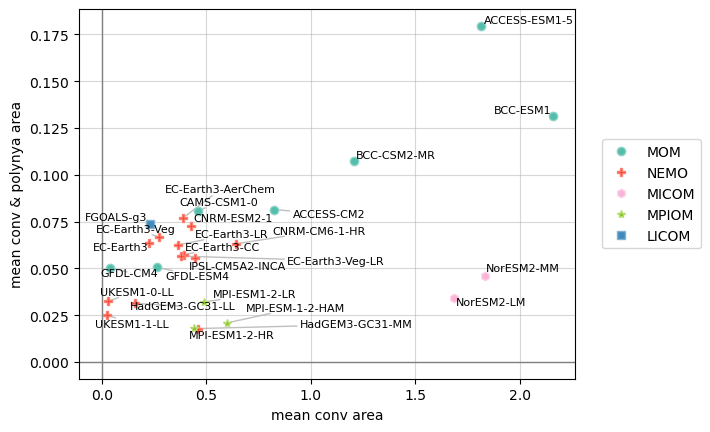

In [30]:
# polynya_areas = []
# c_areas = []
# model_type = []
# names = []
# cp_areas = []

# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    
#     if ispickleexists(name, '../../SO_data/data_mlotst/'):
#         datamld = openpickle(name, '../../SO_data/data_mlotst/')
#         damld = datamld.mlotst
#     else:
#         datamld = openpickle(name, '../../SO_data/data_mld/')
#         damld = datamld.mld
   
#     area_c = datamld.areacello.where(damld>=2000).sum(dim = datamld.areacello.dims)/1e12
#     area_c_total = datamld.areacello.where(damld.where(damld>=2000).mean('time')>0).sum()/1e12
    

#     path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
#     newpath = glob.glob(path_polynya)[0]
#     dsmasked = pd.read_pickle(newpath)
#     dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
#     area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12
#     area_p_total = dssiconc.areacello.where(dsmasked.count('time')>0).sum()/1e12

#     if len(area_c.time) != len(area_p.time):
#         if name in ['KIOST-ESM', 'TaiESM1']:
#             area_c=area_c.sel(time = area_p.time)
#         else:
#             print(name)
#             break
            
    # if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
    #     conv_mask = damld.where(damld>=2000)
    #     try:
    #         area_cp_mask = conv_mask.where(dsmasked>0)
    #         area_cp = datamld.areacello.where(area_cp_mask>0).sum(dim = datamld.areacello.dims)/1e12
    #     except Exception as E:
    #         print(E)
    #         continue

    #     if area_cp.where(area_cp>0).mean()>0:
    #         cp_areas.append(area_cp.where(area_cp>0).mean().values.item())
    #         c_areas.append(area_c.where(area_c>0).mean().values.item())
    #         polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
    #         model_type.append(datapd.at[i, 'type'])
    #         names.append(name)

df_plot = pd.DataFrame({
    'y': cp_areas,
    'x': c_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

# ax.set_xlim([-1, 15])
# ax.set_ylim([-1, 15])

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'abc':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]<=19:# and df_plot['y'][ind]>19:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))


# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean conv area")
ax.set_ylabel("mean conv & polynya area")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


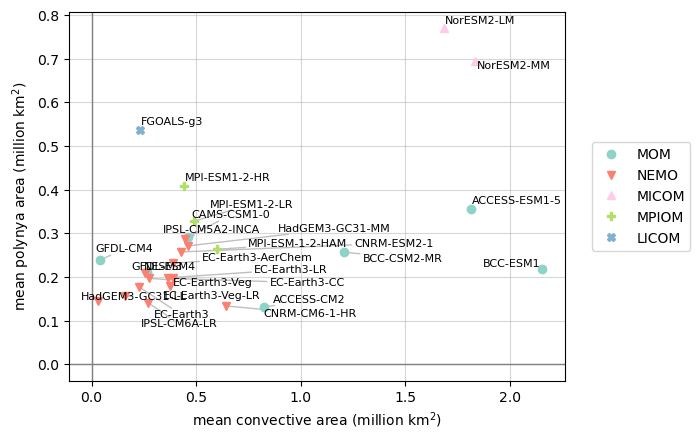

In [9]:
polynya_areas = []
c_areas = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    if ispickleexists(name, '../../SO_data/data_mlotst/'):
        datamld = openpickle(name, '../../SO_data/data_mlotst/')
        damld = datamld.mlotst
    else:
        datamld = openpickle(name, '../../SO_data/data_mld/')
        damld = datamld.mld
   
    area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    
    dsmasked = openpickle(name, '../../SO_data/data_polynya/')
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

    if len(area_c.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            area_c=area_c.sel(time = area_p.time)
        else:
            print(name)
            break
    if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
        c_areas.append(area_c.where(area_c>0).mean().values.item())
        polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': c_areas,
    'name': names,
    'type': model_type
})

marker_list = ['o','v','^','P','X','D','h','*','s','1','.']

fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]>0.1 and df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean convective area (million km$^2$)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


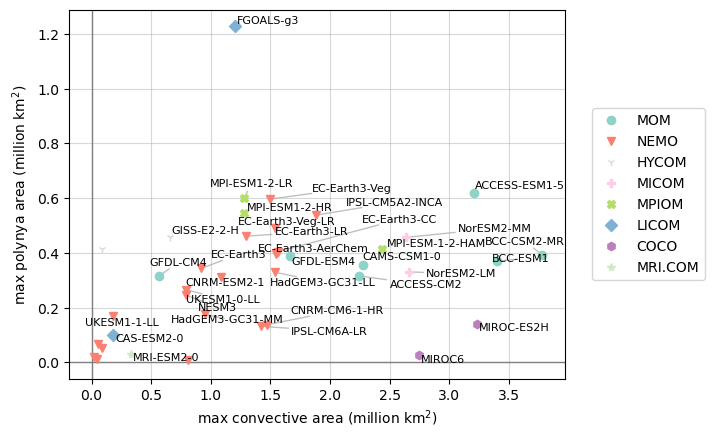

In [60]:
polynya_areas = []
c_areas = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    if ispickleexists(name, '../../SO_data/data_mlotst/'):
        datamld = openpickle(name, '../../SO_data/data_mlotst/')
        damld = datamld.mlotst
    else:
        datamld = openpickle(name, '../../SO_data/data_mld/')
        damld = datamld.mld
   
    area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

    if len(area_c.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            area_c=area_c.sel(time = area_p.time)
        else:
            print(name)
            break
    if (area_c.where(area_c>0).mean() > 0) and (area_p.where(area_p>0).mean()>0):
        c_areas.append(area_c.where(area_c>0).max().values.item())
        polynya_areas.append(area_p.where(area_p>0).max().values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': c_areas,
    'name': names,
    'type': model_type
})


fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['x'][ind]>0.1 and df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("max convective area (million km$^2$)")
ax.set_ylabel("max polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


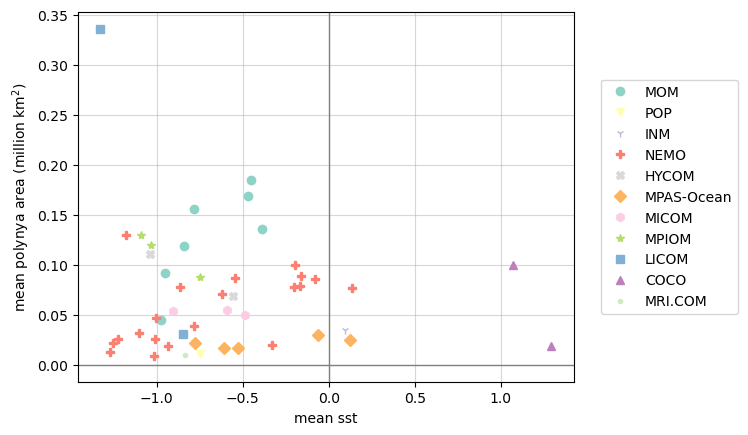

In [104]:
polynya_areas = []
sst_south = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    
    if not ispickleexists(name, '../../SO_data/data_sst/'):
        continue
    sst = openpickle(name, '../../SO_data/data_sst/')
    if 'tos' in sst:
        dssst = sst.tos
    elif 'thetao' in sst:
        dssst = sst.thetao

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

    if len(dssst.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            dssst=dssst.sel(time = area_p.time)
        elif name in ['EC-Earth3-AerChem','IPSL-CM6A-LR']:
            area_p=area_p.sel(time = dssst.time)
        else:
            print(name)
            break
    if area_p.where(area_p>0).mean()>0:
        sst_south.append(dssst.where(sst.newlat<=-55).mean().values.item())
        polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': sst_south,
    'name': names,
    'type': model_type
})

marker_list = ['o','v','1','P','X','D','h','*','s','^','.']

fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

# texts=[]
# newx=[]
# newy=[]
# for ind in df_plot.index:
#     if df_plot['type'][ind] == 'MOM':
#         texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#         newx.append(df_plot['x'][ind])
#         newy.append(df_plot['y'][ind])
#     else:
#         if df_plot['y'][ind]>0.01:
#             texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#             newx.append(df_plot['x'][ind])
#             newy.append(df_plot['y'][ind])

# adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
#             time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
#             arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean sst")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


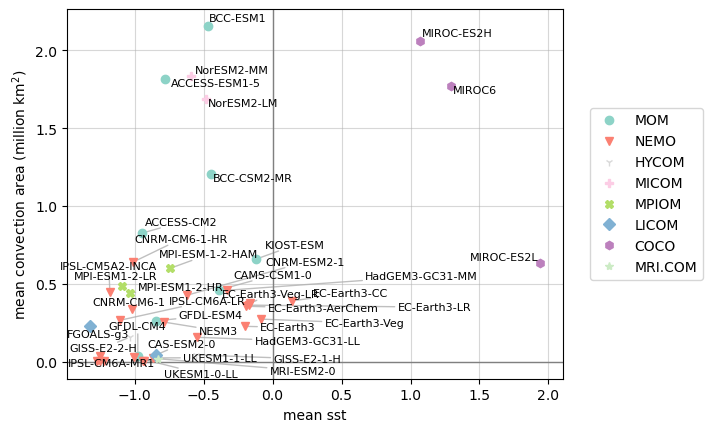

In [79]:
# c_areas = []
# sst_south = []
# model_type = []
# names = []
# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    
    
#     if not ispickleexists(name, '../../SO_data/data_sst/'):
#         continue
#     sst = openpickle(name, '../../SO_data/data_sst/')
#     if 'tos' in sst:
#         dssst = sst.tos
#     elif 'thetao' in sst:
#         dssst = sst.thetao

#     if ispickleexists(name, '../../SO_data/data_mlotst/'):
#         datamld = openpickle(name, '../../SO_data/data_mlotst/')
#         damld = datamld.mlotst
#     else:
#         datamld = openpickle(name, '../../SO_data/data_mld/')
#         damld = datamld.mld
   
#     area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
    

#     if len(dssst.time) != len(area_c.time):
#         if name in ['KIOST-ESM', 'TaiESM1']:
#             dssst=dssst.sel(time = area_c.time)
#         elif name in ['EC-Earth3-AerChem', 'IPSL-CM6A-LR']:
#             area_c=area_c.sel(time = dssst.time)
#         else:
#             print(name)
#             break
#     if area_c.where(area_c>0).mean()>0:
#         sst_south.append(dssst.where(sst.newlat<=-55).mean().values.item())
#         c_areas.append(area_c.where(area_c>0).mean().values.item())    
#         model_type.append(datapd.at[i, 'type'])
#         names.append(name)

# df_plot = pd.DataFrame({
#     'y': c_areas,
#     'x': sst_south,
#     'name': names,
#     'type': model_type
# })

marker_list = ['o','v','1','P','X','D','h','*','s','^','.']

fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean sst")
ax.set_ylabel("mean convection area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


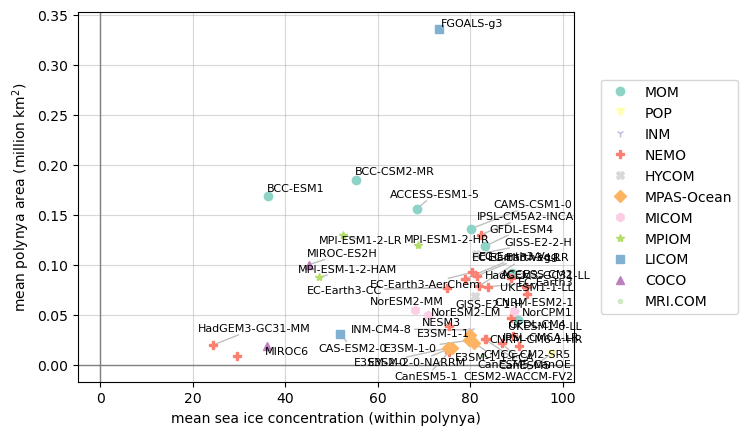

In [81]:
polynya_areas = []
polynya_sic = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12


    if area_p.where(area_p>0).mean()>0:
        polynya_region = dsmasked.where(dsmasked>0).mean('time')
        sic_poly = dssiconc.siconc.where(polynya_region>0).mean()
    
        
        polynya_sic.append(sic_poly.values.item())
        polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': polynya_sic,
    'name': names,
    'type': model_type
})

marker_list = ['o','v','1','P','X','D','h','*','s','^','.']

fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean sea ice concentration (within polynya)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


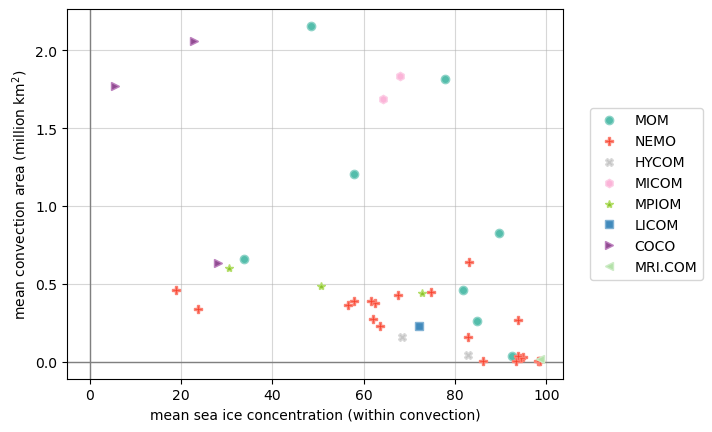

In [25]:
# conv_areas = []
# conv_sic = []
# model_type = []
# names = []
# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    

#     if ispickleexists(name, '../../SO_data/data_mlotst/'):
#         datamld = openpickle(name, '../../SO_data/data_mlotst/')
#         damld = datamld.mlotst
#     else:
#         datamld = openpickle(name, '../../SO_data/data_mld/')
#         damld = datamld.mld
   
#     area_c = datamld.areacello.where(damld>2000).sum(dim = datamld.areacello.dims)/1e12
#     area_c_total = datamld.areacello.where(damld.where(damld>2000).mean('time')>0).sum()/1e12

#     path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
#     newpath = glob.glob(path_polynya)[0]
#     dsmasked = pd.read_pickle(newpath)
#     dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
#     # area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12


#     if area_c.where(area_c>0).mean()>0:
#         conv_region = damld.where(damld>2000).mean('time')
#         try: 
#             sic_conv = dssiconc.siconc.where(conv_region>0).mean()
#         except Exception as E:
#             print(E)
#             continue

#         if not sic_conv<=100:
#             continue
    
#         conv_sic.append(sic_conv.values.item())
#         conv_areas.append(area_c.where(area_c>0).mean().values.item())    
#         model_type.append(datapd.at[i, 'type'])
#         names.append(name)

df_plot = pd.DataFrame({
    'y': conv_areas,
    'x': conv_sic,
    'name': names,
    'type': model_type
})

fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker = marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = lighten_color(color_dict[mtype], 1.5),
            linestyle='', ms=6, label=mtype)
    cc += 1

# texts=[]
# newx=[]
# newy=[]
# for ind in df_plot.index:
#     if df_plot['type'][ind] == 'MOM':
#         texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#         newx.append(df_plot['x'][ind])
#         newy.append(df_plot['y'][ind])
#     else:
#         if df_plot['y'][ind]>0.01:
#             texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#             newx.append(df_plot['x'][ind])
#             newy.append(df_plot['y'][ind])

# adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
#             time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
#             arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean sea ice concentration (within convection)")
ax.set_ylabel("mean convection area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


NESM3 Unable to allocate 1.37 TiB for an array with shape (500, 88, 362, 74, 320) and data type float32
CAS-ESM2-0


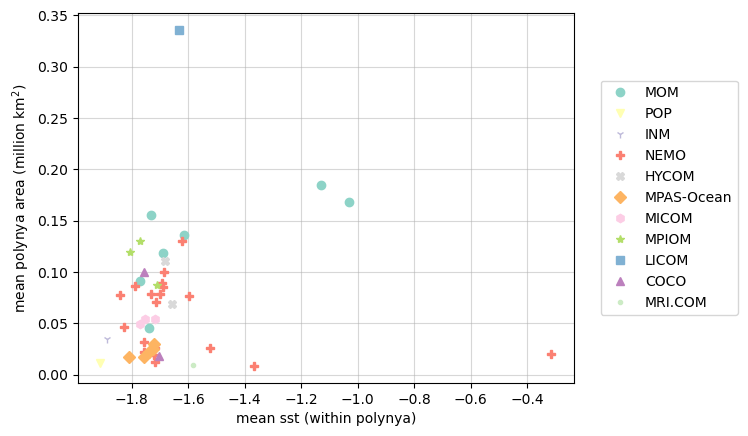

In [105]:
polynya_areas = []
polynya_sst = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    
    if not ispickleexists(name, '../../SO_data/data_sst/'):
        continue
    sst = openpickle(name, '../../SO_data/data_sst/')
    if 'tos' in sst:
        dssst = sst.tos
    elif 'thetao' in sst:
        dssst = sst.thetao

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

    if len(dssst.time) != len(area_p.time):
        if name in ['KIOST-ESM', 'TaiESM1']:
            dssst=dssst.sel(time = area_p.time)
        elif name in ['EC-Earth3-AerChem','IPSL-CM6A-LR']:
            area_p=area_p.sel(time = dssst.time)
        else:
            print(name)
            break
            
    if area_p.where(area_p>0).mean()>0:
        polynya_region = dsmasked.where(dsmasked>0).mean('time')
        try:
            sst_poly = dssst.where(polynya_region>0).mean()
        except Exception as E:
            print(name, E)
            continue
        if not sst_poly >-100:
            print(name)
            continue
        polynya_sst.append(sst_poly.values.item())
        polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': polynya_sst,
    'name': names,
    'type': model_type
})

marker_list = ['o','v','1','P','X','D','h','*','s','^','.']

fig, ax = plt.subplots()
# ax.axvline(c='grey', lw=1)
# ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

# texts=[]
# newx=[]
# newy=[]
# for ind in df_plot.index:
#     if df_plot['type'][ind] == 'MOM':
#         texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#         newx.append(df_plot['x'][ind])
#         newy.append(df_plot['y'][ind])
#     else:
#         if df_plot['y'][ind]>0.01:
#             texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#             newx.append(df_plot['x'][ind])
#             newy.append(df_plot['y'][ind])

# adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
#             time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
#             arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean sst (within polynya)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


In [106]:
sst = openpickle('CAS-ESM2-0', '../../SO_data/data_sst/')

In [108]:
sst.tos

<xarray.DataArray 'tos' (time: 549, lat: 39, lon: 360)> Size: 31MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 8.037345 ,  8.056473 ,  8.094077 , ...,  8.66078  ,
          8.386564 ,  8.16992  ],
        [ 9.068524 ,  9.096038 ,  9.138661 , ...,  9.438832 ,
          9.263694 ,  9.123825 ],
        [ 9.782711 ,  9.749756 ,  9.702111 , ..., 10.056955 ,
          9.932809 ,  9.844118 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [ 8.96753  ,  8.929366 ,  8.957108 , ...,  9.763707 ,
          9.425901 ,  9.144538 ],
        [ 9.883477 ,  9.845763 ,  9.856626 , ..., 10.557923 ,
         10.262021 , 10.023729 ],
        [10.542477 , 10.478158 , 10.41753  , ..., 10.926768 ,
         10.7748   , 10.644499 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 9.3395195,  9.240726 ,  9.193295 , ..., 10.089936 ,
          9.809623 ,  9.525015 ],
        [10.161276 , 10.050487 , 10.019566 , ..., 10.695375 ,
         10.505506 , 10.325535 ],
        [10.5860815, 10.5143   , 10.442755 , ..., 10.966732 ,
         10.837577 , 10.706307 ]]], dtype=float32)
Coordinates:
  * time     (time) object 4kB 0001-09-16 00:00:00 ... 0549-09-16 00:00:00
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 312B -78.0 -77.0 -76.0 -75.0 ... -42.0 -41.0 -40.0
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    history:        2020-12-27T01:31:11Z altered by CMOR: replaced missing va...
    long_name:      Sea Surface Temperature
    standard_name:  sea_surface_temperature
    units:          degC

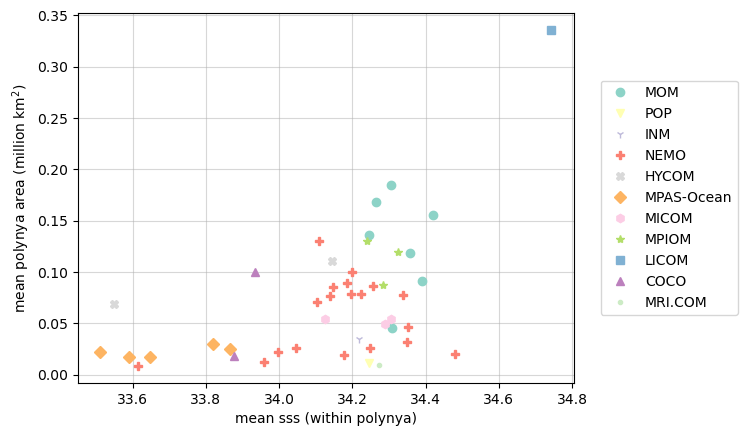

In [97]:
# polynya_areas = []
# polynya_sss = []
# model_type = []
# names = []
# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    
    
#     if not ispickleexists(name, '../../SO_data/data_sos/'):
#         continue
#     sss = openpickle(name, '../../SO_data/data_sos/')
#     if 'so' in sss:
#         dssos = sss.so
#     elif 'sos' in sss:
#         dssos = sss.sos

#     path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
#     newpath = glob.glob(path_polynya)[0]
#     dsmasked = pd.read_pickle(newpath)
#     dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
#     area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

#     if len(dssos.time) != len(area_p.time):
#         if name in ['KIOST-ESM', 'TaiESM1','SAM0-UNICON']:
#             dssos=dssos.sel(time = area_p.time)
#         elif name in ['EC-Earth3-AerChem','IPSL-CM6A-LR']:
#             area_p=area_p.sel(time = dssos.time)
#         else:
#             print(name)
#             break
            
#     if area_p.where(area_p>0).mean()>0:
#         polynya_region = dsmasked.where(dsmasked>0).mean('time')
#         try:
#             sss_poly = dssos.where(polynya_region>0).mean()
#         except Exception as E:
#             print(name, E)
#             continue
#         if not sss_poly >-100:
#             print(name)
#             continue
#         polynya_sss.append(sss_poly.values.item())
#         polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
#         model_type.append(datapd.at[i, 'type'])
#         names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_areas,
    'x': polynya_sss,
    'name': names,
    'type': model_type
})

marker_list = ['o','v','1','P','X','D','h','*','s','^','.']

fig, ax = plt.subplots()
# ax.axvline(c='grey', lw=1)
# ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

# texts=[]
# newx=[]
# newy=[]
# for ind in df_plot.index:
#     if df_plot['type'][ind] == 'MOM':
#         texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#         newx.append(df_plot['x'][ind])
#         newy.append(df_plot['y'][ind])
#     else:
#         if df_plot['y'][ind]>0.01:
#             texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#             newx.append(df_plot['x'][ind])
#             newy.append(df_plot['y'][ind])

# adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
#             time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
#             arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean sss (within polynya)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


In [ ]:
polynya_sst = []
polynya_sss = []
model_type = []
names = []
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']    
    
    if not ispickleexists(name, '../../SO_data/data_sos/'):
        continue
    sss = openpickle(name, '../../SO_data/data_sos/')
    if 'so' in sss:
        dssos = sss.so
    elif 'sos' in sss:
        dssos = sss.sos

    if not ispickleexists(name, '../../SO_data/data_sst/'):
        continue
    sst = openpickle(name, '../../SO_data/data_sst/')
    if 'tos' in sst:
        dssst = sst.tos
    elif 'thetao' in sst:
        dssst = sst.thetao

    path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
    newpath = glob.glob(path_polynya)[0]
    dsmasked = pd.read_pickle(newpath)
    dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
    area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

#     if len(dssos.time) != len(area_p.time):
#         if name in ['KIOST-ESM', 'TaiESM1','SAM0-UNICON']:
#             dssos=dssos.sel(time = area_p.time)
#         elif name in ['EC-Earth3-AerChem','IPSL-CM6A-LR']:
#             area_p=area_p.sel(time = dssos.time)
#         else:
#             print(name)
#             break
            
    if area_p.where(area_p>0).mean()>0:
        polynya_region = dsmasked.where(dsmasked>0).mean('time')
        try:
            sss_poly = dssos.where(polynya_region>0).mean()
            sst_poly = dssst.where(polynya_region>0).mean()
        except Exception as E:
            print(name, E)
            continue
        if not (sss_poly) >-100:
            print(name)
            continue
        if not (sst_poly) >-100:
            print(name)
            continue
        polynya_sss.append(sss_poly.values.item())
        polynya_sst.append(sst_poly.values.item())
        model_type.append(datapd.at[i, 'type'])
        names.append(name)

df_plot = pd.DataFrame({
    'y': polynya_sst,
    'x': polynya_sss,
    'name': names,
    'type': model_type
})

fig, ax = plt.subplots()
# ax.axvline(c='grey', lw=1)
# ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_dict[mtype], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

# texts=[]
# newx=[]
# newy=[]
# for ind in df_plot.index:
#     if df_plot['type'][ind] == 'MOM':
#         texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#         newx.append(df_plot['x'][ind])
#         newy.append(df_plot['y'][ind])
#     else:
#         if df_plot['y'][ind]>0.01:
#             texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
#             newx.append(df_plot['x'][ind])
#             newy.append(df_plot['y'][ind])

# adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
#             time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
#             arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean sss (within polynya)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")


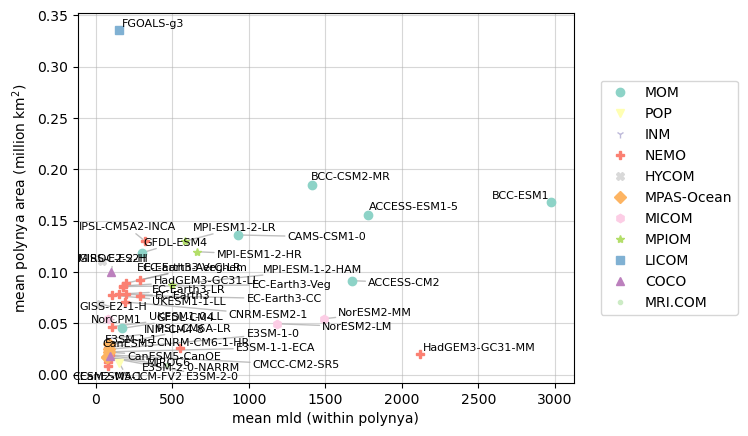

In [103]:
# polynya_areas = []
# polynya_mld = []
# model_type = []
# names = []
# for i in range(0, len(datapd)):
#     name = datapd.at[i, 'source_id']    
    
#     if ispickleexists(name, '../../SO_data/data_mlotst/'):
#         datamld = openpickle(name, '../../SO_data/data_mlotst/')
#         damld = datamld.mlotst
#     else:
#         datamld = openpickle(name, '../../SO_data/data_mld/')
#         damld = datamld.mld

#     path_polynya = '../../SO_data/data_polynya_max_mean/' + name + '_meannot0_*.pickle'
#     newpath = glob.glob(path_polynya)[0]
#     dsmasked = pd.read_pickle(newpath)
#     dssiconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
#     area_p = dssiconc.areacello.where(dsmasked>0).sum(dim = dssiconc.areacello.dims)/1e12

#     if len(damld.time) != len(area_p.time):
#         if name in ['KIOST-ESM', 'TaiESM1']:
#             damld=damld.sel(time = area_p.time)
#         elif name in ['EC-Earth3-AerChem','IPSL-CM6A-LR']:
#             area_p=area_p.sel(time = damld.time)
#         else:
#             print(name)
#             break
            
#     if area_p.where(area_p>0).mean()>0:
#         polynya_region = dsmasked.where(dsmasked>0).mean('time')
#         try:
#             mld_poly = damld.where(polynya_region>0).mean()
#         except Exception as E:
#             print(name, E)
#             continue
#         if not mld_poly >-100:
#             print(name)
#             continue
#         polynya_mld.append(mld_poly.values.item())
#         polynya_areas.append(area_p.where(area_p>0).mean().values.item())    
#         model_type.append(datapd.at[i, 'type'])
#         names.append(name)

# df_plot = pd.DataFrame({
#     'y': polynya_areas,
#     'x': polynya_mld,
#     'name': names,
#     'type': model_type
# })

marker_list = ['o','v','1','P','X','D','h','*','s','^','.']

fig, ax = plt.subplots()
# ax.axvline(c='grey', lw=1)
# ax.axhline(c='grey', lw=1)
cc = 0
for mtype in df_plot['type'].unique():
    plotdata_df = df_plot.loc[df_plot['type'] == mtype]

    ax.plot(plotdata_df.x, plotdata_df.y, 
            marker=marker_list[cc], 
            markeredgecolor = color_dict[mtype],
            markerfacecolor = color_dict[mtype],
            linestyle='', ms=6, label=mtype)
    cc += 1

texts=[]
newx=[]
newy=[]
for ind in df_plot.index:
    if df_plot['type'][ind] == 'MOM':
        texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
        newx.append(df_plot['x'][ind])
        newy.append(df_plot['y'][ind])
    else:
        if df_plot['y'][ind]>0.01:
            texts+=[ax.text(df_plot['x'][ind], df_plot['y'][ind], df_plot['name'][ind], fontsize = 8)] # for adjustText
            newx.append(df_plot['x'][ind])
            newy.append(df_plot['y'][ind])

adjust_text(texts, newx, newy, ax=ax, #avoid_self=True, #force_explode = (0.2, 0.2),
            time_lim=1, #Give it 1 second instead of 0.1 sec to arrange such dense labels
            arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))

# ax.set_xlim([-0.1, 2.5])
# ax.set_ylim([-0.1, 2.5])
# ax.set_aspect('equal', adjustable='box')

# ax.set_xticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_xticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
# ax.set_yticks(np.linspace(0,8,5), minor=False) # only the 50% is major
# ax.set_yticks(np.linspace(-1,8,10), minor=True) # all 10th are minor
ax.grid(which='both', axis='both',alpha=.5) # draw grid
ax.set_xlabel("mean mld (within polynya)")
ax.set_ylabel("mean polynya area (million km$^2$)")
ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
# ax.legend(loc="upper left")
